<a href="https://colab.research.google.com/github/rootofdata/Outlier_Detection/blob/main/EDA_sensor(ver3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised outlier detection for Time series data using LSTM + AE (ver3)  
### Feature : TMP,HMD,CO,H2S,NO2,TVOC,CO2,NH3,PM10 (9 features)
### Time : 2022-3-23 ~

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#필요한 라이브러리 호출

In [ ]:
from glob import glob
import os

import pandas as pd
import numpy as np
import datetime
import time

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False   # 한글 폰트 패치.

import warnings
warnings.filterwarnings('ignore')   # 경고문 처리.

from sklearn.preprocessing import StandardScaler

In [ ]:
df_ver3=pd.read_csv('/content/drive/MyDrive/Outlier Detection Paper/data/구버전/10000000-data-2022-04-28 10_38_08.csv')
df_ver3[2000:2500]

,time,entity_id,ts2,ch2o,pm2_5,pm10,tvoc,co2,tmp,rh,cpm,db,co,stink,no2,h2s,nh3
2000,2022-04-24 05:21:51,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-23 20:21:51,61,15,27,998,541,13.8,29.6,0,35,0,0,0,0,0
2001,2022-04-24 05:23:51,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-23 20:23:51,61,15,27,1001,545,13.8,29.6,0,39,0,0,0,0,0
2002,2022-04-24 05:25:51,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-23 20:25:51,60,15,27,998,544,13.8,29.7,0,42,0,0,0,0,0
2003,2022-04-24 05:27:51,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-23 20:27:51,61,15,27,1001,543,15.2,29.6,0,44,0,0,0,0,0
2004,2022-04-24 05:29:51,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-23 20:29:51,62,15,27,1000,547,13.9,29.5,0,43,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2022-04-24 21:52:26,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-24 12:52:26,72,15,27,1349,578,14.2,32.4,0,42,0,0,0,0,0
2496,2022-04-24 21:54:27,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-24 12:54:27,73,15,27,1359,577,15.6,32.4,0,37,0,0,0,0,0
2497,2022-04-24 21:56:27,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-24 12:56:27,72,15,27,1353,579,14.1,32.6,0,35,0,0,0,0,0
2498,2022-04-24 21:58:27,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-24 12:58:27,74,15,27,1359,579,14.1,32.6,0,43,0,0,0,0,0


In [ ]:
df_ver3['time'] = pd.to_datetime(df_ver3['time'])
df_ver3 = df_ver3.sort_values('time')
df_ver3['time'] = df_ver3['time'].dt.to_period(freq = 'min')  #분까지 끊기
df_ver3

,time,entity_id,ts2,ch2o,pm2_5,pm10,tvoc,co2,tmp,rh,cpm,db,co,stink,no2,h2s,nh3
0,2022-04-21 10:39,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-21 01:39:26,55,20,38,804,529,13.8,26.1,0,36,0,0,0,0,0
1,2022-04-21 10:41,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-21 01:41:26,53,20,38,811,534,13.9,26.0,0,38,0,0,0,0,0
2,2022-04-21 10:43,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-21 01:43:26,54,20,37,804,538,14.0,25.9,0,39,0,0,0,0,0
3,2022-04-21 10:45,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-21 01:45:26,54,20,38,811,540,13.9,26.0,0,37,0,0,0,0,0
4,2022-04-21 10:47,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-21 01:47:26,55,20,37,816,543,15.3,26.0,0,33,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999,2022-04-28 10:26,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-28 01:26:09,63,12,23,804,494,15.0,27.7,0,40,0,0,0,0,0
5000,2022-04-28 10:28,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-28 01:28:08,63,13,24,817,492,16.5,27.5,0,40,0,0,0,0,0
5001,2022-04-28 10:30,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-28 01:30:08,61,13,23,808,495,15.2,27.5,0,40,0,0,0,0,0
5002,2022-04-28 10:32,24133a80-144d-11ec-80c8-b1d8e607054f,2022-04-28 01:32:08,60,13,24,808,494,15.1,27.6,0,35,0,0,0,0,0


데이터프레임을 보면, 짝수분이다가 시간이 밀려 홀수분이 되고,   
홀수분에서 짝수분이 될때도 시간이 밀려 짝수분이 된다.  
11:20 11:22 11:25... 12:27 12:29 12:32  
-> 해결 방안 : 홀수분일때 앞으로 땡겨 짝수분으로 만들어주고, 마지막 홀수분 이후 한 행 추가.   
(단순 홀수분일때 앞으로 땡기기만 하면 됨.)

In [ ]:
time =df_ver3['time'].apply(lambda x: x.strftime('%Y%m%d%H%M'))

for i in range(len(df_ver3['time'])):
  if int(time[i][-2:])%2 ==1:
    df_ver3['time'][i]=df_ver3['time'][i]+datetime.timedelta(minutes=1)

setting 날짜 범위 시작, 날짜 범위 끝

In [ ]:
ver3_frame = pd.date_range(start = '2022-04-21 10:38',            # 날짜 범위 시작
                     end = '2022-04-28 10:34',                    # 날짜 범위 끝
                     freq = '2min',                           # 시간 간격( 2분 간격)
                     tz = 'Asia/Seoul')                       # 시간대(timezone)
ver3_frame=pd.DataFrame(ver3_frame)
ver3_frame.columns=['time']
ver3_frame['time'] = ver3_frame['time'].dt.to_period(freq = 'min')  #분까지 끊기
ver3_frame

,time
0,2022-04-21 10:38
1,2022-04-21 10:40
2,2022-04-21 10:42
3,2022-04-21 10:44
4,2022-04-21 10:46
...,...
5034,2022-04-28 10:26
5035,2022-04-28 10:28
5036,2022-04-28 10:30
5037,2022-04-28 10:32


In [ ]:
new_df_ver3 = pd.merge(ver3_frame,df_ver3, how='outer',on='time')
new_df_ver3.sort_values(['time'],inplace=True)
new_df_ver3.reset_index(drop=True,inplace=True)
new_df_ver3.drop(['ts2','entity_id'],axis=1,inplace=True)
new_df_ver3=new_df_ver3.set_index('time')
new_df_ver3[1:]

,ch2o,pm2_5,pm10,tvoc,co2,tmp,rh,cpm,db,co,stink,no2,h2s,nh3
time,,,,,,,,,,,,,,
2022-04-21 10:40,55.0,20.0,38.0,804.0,529.0,13.8,26.1,0.0,36.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:42,53.0,20.0,38.0,811.0,534.0,13.9,26.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:44,54.0,20.0,37.0,804.0,538.0,14.0,25.9,0.0,39.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:46,54.0,20.0,38.0,811.0,540.0,13.9,26.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:48,55.0,20.0,37.0,816.0,543.0,15.3,26.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28 10:26,63.0,12.0,23.0,804.0,494.0,15.0,27.7,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2022-04-28 10:28,63.0,13.0,24.0,817.0,492.0,16.5,27.5,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2022-04-28 10:30,61.0,13.0,23.0,808.0,495.0,15.2,27.5,0.0,40.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
ver3=new_df_ver3.interpolate()
ver3

,ch2o,pm2_5,pm10,tvoc,co2,tmp,rh,cpm,db,co,stink,no2,h2s,nh3
time,,,,,,,,,,,,,,
2022-04-21 10:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-04-21 10:40,55.0,20.0,38.0,804.0,529.0,13.8,26.1,0.0,36.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:42,53.0,20.0,38.0,811.0,534.0,13.9,26.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:44,54.0,20.0,37.0,804.0,538.0,14.0,25.9,0.0,39.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:46,54.0,20.0,38.0,811.0,540.0,13.9,26.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28 10:26,63.0,12.0,23.0,804.0,494.0,15.0,27.7,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2022-04-28 10:28,63.0,13.0,24.0,817.0,492.0,16.5,27.5,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2022-04-28 10:30,61.0,13.0,23.0,808.0,495.0,15.2,27.5,0.0,40.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#확인
ver3[1:].isnull().sum()

ch2o     0
pm2_5    0
pm10     0
tvoc     0
co2      0
tmp      0
rh       0
cpm      0
db       0
co       0
stink    0
no2      0
h2s      0
nh3      0
dtype: int64

In [ ]:
ver3[1:]

,ch2o,pm2_5,pm10,tvoc,co2,tmp,rh,cpm,db,co,stink,no2,h2s,nh3
time,,,,,,,,,,,,,,
2022-04-21 10:40,55.0,20.0,38.0,804.0,529.0,13.8,26.1,0.0,36.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:42,53.0,20.0,38.0,811.0,534.0,13.9,26.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:44,54.0,20.0,37.0,804.0,538.0,14.0,25.9,0.0,39.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:46,54.0,20.0,38.0,811.0,540.0,13.9,26.0,0.0,37.0,0.0,0.0,0.0,0.0,0.0
2022-04-21 10:48,55.0,20.0,37.0,816.0,543.0,15.3,26.0,0.0,33.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-28 10:26,63.0,12.0,23.0,804.0,494.0,15.0,27.7,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2022-04-28 10:28,63.0,13.0,24.0,817.0,492.0,16.5,27.5,0.0,40.0,0.0,0.0,0.0,0.0,0.0
2022-04-28 10:30,61.0,13.0,23.0,808.0,495.0,15.2,27.5,0.0,40.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(ver3)
df_scaled = pd.DataFrame(df_scaled,columns=ver3.columns.to_list())

In [ ]:
df_scaled[1:]

,ch2o,pm2_5,pm10,tvoc,co2,tmp,rh,cpm,db,co,stink,no2,h2s,nh3
1,-0.752542,-0.130664,-0.078128,-1.087816,-0.195451,-1.267750,-1.465304,0.0,-0.927625,0.0,0.0,0.0,0.0,0.0
2,-0.835656,-0.130664,-0.078128,-1.074519,-0.146851,-1.161750,-1.491001,0.0,-0.210377,0.0,0.0,0.0,0.0,0.0
3,-0.794099,-0.130664,-0.112454,-1.087816,-0.107970,-1.055750,-1.516699,0.0,0.148246,0.0,0.0,0.0,0.0,0.0
4,-0.794099,-0.130664,-0.078128,-1.074519,-0.088530,-1.161750,-1.491001,0.0,-0.569001,0.0,0.0,0.0,0.0,0.0
5,-0.752542,-0.130664,-0.112454,-1.065021,-0.059370,0.322249,-1.491001,0.0,-2.003496,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5035,-0.420084,-0.645076,-0.593018,-1.087816,-0.535654,0.004249,-1.054142,0.0,0.506870,0.0,0.0,0.0,0.0,0.0
5036,-0.420084,-0.580775,-0.558692,-1.063121,-0.555095,1.594248,-1.105537,0.0,0.506870,0.0,0.0,0.0,0.0,0.0
5037,-0.503198,-0.580775,-0.593018,-1.080218,-0.525934,0.216249,-1.105537,0.0,0.506870,0.0,0.0,0.0,0.0,0.0
5038,-0.544756,-0.580775,-0.558692,-1.080218,-0.535654,0.110249,-1.079840,0.0,-1.286248,0.0,0.0,0.0,0.0,0.0


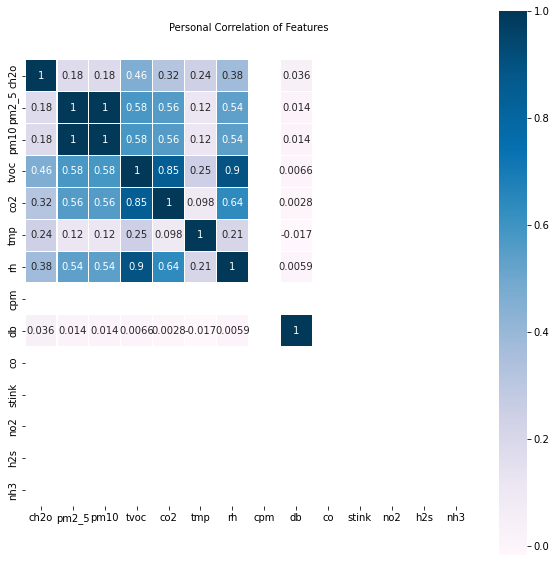

In [ ]:
colormap = plt.cm.PuBu 
plt.figure(figsize=(10, 10)) 
plt.title("Personal Correlation of Features", y = 1.05, size = 10) 
sns.heatmap(df_scaled[1:].corr(), linewidths = 0.1, vmax = 1.0,
            square = True, cmap = colormap, linecolor = "white", annot = True, 
            annot_kws = {"size" : 10})
plt.show()